keras version:  2.2.0
TensorFlow version:  1.7.1

Load images...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


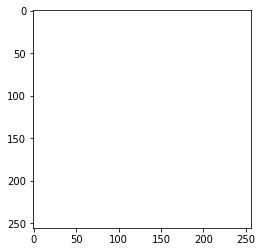

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [ ]:
# fold
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import optimizers
# For some reason I have to tell it to use TensorFlows dimension ordering
from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.callbacks import TensorBoard
from time import time
import os
import tensorflow as tf
from keras import applications
from keras.utils import multi_gpu_model

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.visible_device_list = "2,3"
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Globals

NORMALISE = 1
CLASSDIR_0 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/crops256/normal/*'
CLASSDIR_1 = '/vol/vssp/cvpwrkspc01/scratch/wm0015/crops256/malignant/*'
BATCH_SIZE = 128
EPOCHS = 150
INPUT_SHAPE = [256, 256, 3]
FOLDS = 1

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='/vol/vssp/mammo2/will/logs/new', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        fCount=0
        while os.path.exists(os.path.join(log_dir, 'training' + '_' + str(fCount))):
            fCount+=1
        training_log_dir = os.path.join(log_dir, 'training' + '_' + str(fCount))
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation' + '_' + str(fCount))

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()


def get_images(path, dataSpecs):
    fileList = glob.glob(path) #'BengaliBMPConvert/*.bmp'   
    num = len(fileList)
    dataSpecs['classLength'].append(len(fileList))
    x = np.array([(cv2.imread(fname)) for fname in fileList])
    return x

def get_labels_one_hot(num_classes, class_id, num_samples):
    x = np.zeros((num_samples, num_classes))
    x[np.arange(num_samples),class_id] = 1
    return x

def fourCNN():
    model = Sequential()
    # Layer 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE, data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2
    model.add(Conv2D(32, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 3    
    model.add(Conv2D(32, (3,3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 4     
    model.add(Conv2D(32, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    # Layer 5     
    #model.add(Conv2D(32, (3,3), activation='relu'))   
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 6
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    return model
    
def fiveCNN():
    model = Sequential()
    # Layer 1
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=INPUT_SHAPE, data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 2
    model.add(Conv2D(32, (3,3), activation='relu')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 3    
    model.add(Conv2D(32, (3,3), activation='relu'))  
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 4     
    model.add(Conv2D(32, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    # Layer 5     
    model.add(Conv2D(32, (3,3), activation='relu'))   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer 6
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))  
    return model

def vgg():
    vggModel = applications.VGG19(weights = None, include_top=False, input_shape = INPUT_SHAPE)
    # Add custom final layer
    model = vggModel.output
    model = Flatten()(model)
    model = Dense(2, activation='softmax')(model)
    model = keras.models.Model(inputs=vggModel.input, outputs=model)
    return model

def tlVGG(train_data, val_data):
    print('Compute bottleneck features...')
    vggModel = applications.VGG19(weights = "imagenet", include_top=False, input_shape = INPUT_SHAPE)
    # Freeze all layers
    for layer in vggModel.layers:
        layer.trainable = False
    # Add custom final layer
    bNModel = vggModel.output
    bNModel = Flatten()(bNModel)
    final_model = keras.models.Model(inputs=vggModel.input, outputs=bNModel)
    train_bNFeatures = {'img': 0, 'label': train_data['label']}
    val_bNFeatures = {'img': 0, 'label': val_data['label']}
    train_bNFeatures['img'] = final_model.predict(train_data['img'], batch_size=16)
    val_bNFeatures['img'] = final_model.predict(val_data['img'], batch_size=16)
    print('train_bNFeatures[img].shape = ', train_bNFeatures['img'].shape)
    print('val_bNFeatures[img].shape = ', val_bNFeatures['img'].shape)

    print('Train head...')
    head = Sequential()
    #head.add(Dense(32, input_dim=train_bNFeatures['img'].shape[1], activation='relu'))
    head.add(Dense(2, activation='softmax'))    
    return head, train_bNFeatures, val_bNFeatures


    
    
    
def main():
    import keras
    print('keras version: ', keras.__version__)
    print('TensorFlow version: ', tf.__version__)
    print('\nLoad images...')
    
    # Get images and labels
    data = {'img': 0, 'label': 0}
    dataSpecs = {'classLength': []}
    dataSpecs['classLength'] = []
    data['img'] = np.concatenate((
            get_images(CLASSDIR_0, dataSpecs), # Class 0
            get_images(CLASSDIR_1, dataSpecs) # Class 1
    ))      

    # Normalise
    data['img'] = data['img']/NORMALISE   
    # Print image    
    img_calc = data['img']   
    plt.imshow(img_calc[0], cmap='gray')
    plt.show()
    
    # Create one hot labels
    labels_bg = get_labels_one_hot(2, 0, dataSpecs['classLength'][0])  
    labels_calc = get_labels_one_hot(2, 1, dataSpecs['classLength'][1])
    data['label'] = np.concatenate((
            get_labels_one_hot(2, 0, dataSpecs['classLength'][0]), # Class 0 
            get_labels_one_hot(2, 1, dataSpecs['classLength'][1]) # Class 1
    ))
    # Drop from 3 colour channels to 1 (greyscale)
    if 1==0:
        data['img'] = data['img'][:,:,:,0]
        data['img'] = np.reshape(data['img'], (data['img'].shape[0],data['img'].shape[1],data['img'].shape[2],1))
        print('new data shape = ', data['img'].shape)
    
    valStats = []
    for crossVal in range(FOLDS):

        # Shuffle data
        seed = 33
    #     np.random.seed(seed) # Has to be set before each use of random
        shuffleMask = np.random.permutation(data['img'].shape[0])    
        data['img'] = data['img'][shuffleMask, :, :, :]
        data['label'] = data['label'][shuffleMask, :]

        # Split traing and validation data        
        splitRatio = 0.9
        splitPoint = math.floor(data['img'].shape[0]*splitRatio)
        train_data = {'img': data['img'][0:splitPoint], 'label': data['label'][0:splitPoint]}
        val_data = {'img': data['img'][splitPoint:], 'label': data['label'][splitPoint:]}

        #model, train_bNFeatures, val_data = tlVGG(train_data, val_data)
        model = vgg()        
        model.summary()  
        model = multi_gpu_model(model, gpus=2)
        
        sgd = optimizers.SGD(lr=5, decay=1e-6, momentum=0.9, nesterov=True)
        adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #0.001
        model.compile(loss='binary_crossentropy',
                    optimizer=adam,
                     metrics=['accuracy'])
        tensorboard = TensorBoard(log_dir='/vol/vssp/mammo2/will/logs/new'.format(time()), write_images=True)


        # Train
        model.fit(train_data['img'], train_data['label'], 
                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1,
                callbacks=[TrainValTensorBoard(write_graph=False)],
                validation_data=(val_data['img'], val_data['label']))

        # Evaluate
        score = model.evaluate(val_data['img'], val_data['label'], verbose=0)
        valStats.append(score)
        print('The score is......\n', score)
        
  

    valStats = np.asarray(valStats)
    print('Validations: \n', valStats[:, 1])
    print('Average loss: ', sum(valStats[:, 0])/FOLDS)
    print('Average validation: ', sum(valStats[:, 1])/FOLDS)
    
if __name__ == "__main__":
    main()

In [2]:
print('hello world')

hello world


In [6]:
def test():
    return 1, 2, 3

x, y, z = test()
print(x)
print(y)dd
print(z)

1
2
3


In [35]:
x = [[6.5308382717179665, 0.5925925925925926], [0.16470135086112553, 0.9444444444444444], [0.15422181794304907, 0.9444444444444444], [0.19875195217721256, 0.9382716049382716]] 
x = np.asarray(x)
print(x, '\n')
print(x[0][0])
print(x[:, 0])
print(x.shape)

[[6.53083827 0.59259259]
 [0.16470135 0.94444444]
 [0.15422182 0.94444444]
 [0.19875195 0.9382716 ]] 

6.5308382717179665
[6.53083827 0.16470135 0.15422182 0.19875195]
(4, 2)
